# SLT-CE-8: Model Validation

**Solve the main part of the exercise to get 1 point. Solve the extension as well to get 2 points.**

## References 

[1] [Information Theoretic Model Selection for Pattern Analysis](https://proceedings.mlr.press/v27/buhmann12a/buhmann12a.pdf)

[2] [An extensive comparative study of cluster validity indices](https://www.sciencedirect.com/science/article/pii/S003132031200338X)

[3] [Clustering Indices](https://cran.r-project.org/web/packages/clusterCrit/vignettes/clusterCrit.pdf)


## Introduction

We return to the problem of k-means clustering, but this time the goal is to find the optimal number of clusters.
Having read the reference paper [1], we will try reproduce the experiments detailed in their section 4.1.
However, instead of a Gaussian Mixture Model, we are going to use modified setups, see below. Use Deterministic Annealing to perform clustering. You can reuse your DA algorithms from coding exercise 3.

## Setup

We start by importing necessary python packages.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
import sklearn as skl

from sklearn.utils.validation import check_is_fitted

from scipy.special import logsumexp # for softmax
from scipy.linalg import eigh
from sklearn.metrics import mutual_info_score

## Problem 0

Explain the main idea behind the Model Validation. Write down the equations yuo are going to use for solving the problems and shortly explain the variables that are involved (check section 4.1 in [1]):

In order to compare the stability of cost functions $R(c, \mathbf{X}) \in \mathcal{R}$ under noise in the data $\mathbf{X} \sim \mathbb{P}(\mathbf{X})$, approximation set coding considers a communication scenario including a sender, a problem generator and a receiver. Each entity is initially given access to a sample $\mathbf{X^{(1)}} \sim \mathbb{P}(\mathbf{X})$ and an optimal solution $c^\bot(\mathbf{X^{(1)}}) \in \arg \max_{c\in\mathcal{C}} R(c, \mathbf{X^{(1)}})$. The sender then chooses a transformation $\tau_s \in \mathbb{T}$, $|\mathbb{T}| = 2^{n\rho}$ which acts on the solution space (by permuting elements of the dataset in the case of clustering) and sends it to the problem generator, which generates another sample $\mathbf{X^{(2)}} \sim \mathbb{P}(\mathbf{X})$ and sends $\tau_s \circ \mathbf{X}^{(2)}$ to the receiver. The receiver then estimates $\tau_s$ by maximizing the posterior agreement between $\mathbb{P}(c|\beta, \mathbf{X}^{(1)}) \propto \exp(-\beta R(c,\mathbf{X}^{(1)}))$ and $\mathbb{P}(c|\beta, \tau \circ \mathbf{X}^{(2)}) \propto \exp(-\beta R(c,\tau \circ \mathbf{X}^{(2)}))$, returning $\hat\tau \in \arg \max_{\tau \sum \mathbb{T}} \sum_{c\in\mathcal{C}} \exp(-\beta(R(c,\mathbf{X}^{(1)} + R(c,\tau \circ \mathbf{X}^{(2)}))$. Here $\beta$ represents the degree to which the data is trusted; the larger the noise in the data, the lower $\beta$ has to be chosen to prevent decoding errors. The decoding error $\mathbb{P}(\hat\tau \neq \tau_s|\tau_s)$ can be shown to vanish asymptotically if the rate of transmission $\rho$ falls below the mutual information $$\mathcal{I}_\beta(\tau_s,\hat\tau) = \frac{1}{n} \log \frac{|\{\tau_s\}|\mathcal{Z}_{12}}{\mathcal{Z}_1 \mathcal{Z}_2},$$
where $\mathcal{Z}_1 = \sum_{c\in\mathcal{C}} \exp(-\beta R(c,\mathbf{X^{(1)}}))$, $\mathcal{Z}_2 = \sum_{c\in\mathcal{C}} \exp(-\beta R(c,\mathbf{X^{(2)}}))$, $\mathcal{Z}_{12} = \sum_{c\in\mathcal{C}} \exp(-\beta (R(c,\mathbf{X^{(1)}})+R(c,\mathbf{X^{(2)}})))$ and $|\{\tau_s\}|$ is the number of possible realizations of $c^\bot(\tau_s \circ \mathbf{X}^{(2)})$. 

The approximation capacity is then defined as the maximum of $\mathcal{I}_\beta$ over all inverse temperatures $\beta$. Then to apply model selection on $\mathcal{R}$, we split a given dataset $\mathbf{X}$ randomly into two datasets $\mathbf{X}^{(1)}$ and $\mathbf{X}^{(2)}$, compute the mutual information $\mathcal{I}_\beta$ for each $R \in \mathcal{R}$, maximize it with respect to $\beta$, and choose the cost function with the largest approximation capacity.

For k-means clustering, we have $R(c, \mathbf{X}; \mathbf{Y}) = \sum_{i=1}^n \epsilon_{i,c(i)}$ where $\epsilon_{ik} = \epsilon_{ik}(\mathbf{X}, \mathbf{Y}) = \|x_i - y_k\|^2$ and $\mathbf{Y}$ are the cluster centroids inferred by maximizing the entropy of $\mathbb{P}(c|\beta, \mathbf{X})$. For $\epsilon^{(i)}_{ik} = \epsilon_{ik}(\mathbf{X}^{(i)}, \mathbf{Y})$ the mutual information is calculated as
$$\mathcal{I}_\beta = \frac{1}{n} \log |\{\tau_s\}| + \frac{1}{n} \sum_{i=1}^n \log \frac{\sum_{k=1}^K e^{-\beta(\epsilon^{(1)}_{ik}+\epsilon^{(2)}_{ik})}}{\sum_{k=1}^K e^{-\beta\epsilon^{(1)}_{ik}} \sum_{k=1}^K e^{-\beta\epsilon^{(2)}_{ik}}}$$
where $|\{\tau_s\}|$ is the number of distinct clusterings on $\mathbf{X}^{(1)}$. 

Then to evaluate the approximation capacity of the k-means cost function, we use deterministic annealing to compute the optimal centroids and costs $R(c, \mathbf{X}^{(i)})$ at different temperatures $T = \beta^{-1}$, allowing for $2K$ possible clusters to enable overfitting, and choose as stopping temperature the one with the highest mutual information, balancing informativeness and robustness.

## Problem 1

For this excercise we shall use the following data source:

$$p(\textbf{x})=\frac{1}{2}\mathcal{N}(\textbf{x} | \textbf{0}, \sigma_1^2\mathbb{I}) + 
\frac{1}{2}\mathcal{N}(\textbf{x} | r\textbf{v},\sigma_2^2\mathbb{I}) $$

with $\mathbf{x}, \mathbf{v} \in \mathbb{R}^d$, $\lVert \mathbf{v} \rVert=1$ and $r\in\mathbb{R}_+$.

Implement a function generating data from this distribution:

In [2]:
def generate_data(var_1, var_2, r, v, num_samples):
    """Generate data from the described model using provided parameters:
    Args:
            var_1 (number): varience of the first cluster
            var_2 (number): varience of the second cluster
            r (number): distance r to the center of the second cluster
            v (np.ndarray): direction v of the center of the second cluster
            num_samples (number): number of points to be generated
    
    Returns:
            data (np.ndarray): generated points
            labels (np.ndarray): true cluster assigment for the generated points 
    """
    # generate samples from both distributions, then multiplex
    data1 = var_1 * np.random.randn(num_samples, v.shape[0]) # assuming v is 1D
    data2 = var_2 * np.random.randn(num_samples, v.shape[0]) + r*v
    labels = np.random.binomial(1, .5, num_samples)
    data = (data1.T * (labels==0) + data2.T * (labels==1)).T
    return data, labels

Generate and plot 2D points for different combinations of $\sigma_1$, $\sigma_2$ and $r$. Color generated points according to the cluster assigment.

In [3]:
# fix random seed for reproducibility
np.random.seed(42)

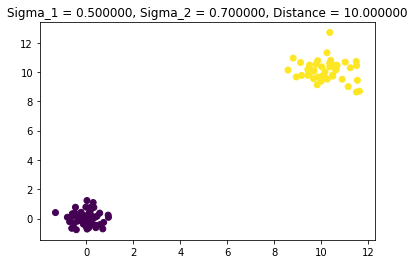

In [4]:
var_1 = 0.5
var_2 = 0.7
r = 10
v = np.array([1, 1])
n_samples = 100
data, labels = generate_data(var_1, var_2, r, v, n_samples)
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title("Sigma_1 = %f, Sigma_2 = %f, Distance = %f" % (var_1, var_2, r))
plt.show()

## Problem 2
In order to reproduce the results described in the reference paper [1], section 4.1, we need to calculate mutual information of two clusterings. Provide an implementation of the correspondent function according to its docstring. You may want to check section 3 in [1] for more details.

In [5]:
def mutual_information(X_1, X_2, y_1, y_2, t):
    """Compute mutual information of two clusterings
    Args:
        x_1 (np.ndarray): first dataset
        x_2 (np.ndarray): second dataset
        y_1 (np.ndarray): cluster centers for the first dataset
        y_2 (np.ndarray): cluster centers for the second dataset
        t (float): temperature T
    Returns:
        mutual_information (float): mutual information of x_1 and x_2
    """
    assert X_1.shape == X_2.shape and y_1.shape == y_2.shape
    n, d = X_1.shape
    K, d = y_1.shape
    
    # calculate squared distances for both datasets
    d1 = np.linalg.norm(X_1.reshape(n, 1, d) - \
                        y_1.reshape(1, K, d), axis=2)**2
    d2 = np.linalg.norm(X_2.reshape(n, 1, d) - \
                        y_2.reshape(1, K, d), axis=2)**2
    # calculate individual and joint log partition functions for each i
    z1  = logsumexp(-d1/t, axis=1)
    z2  = logsumexp(-d2/t, axis=1)
    z12 = logsumexp(-(d1+d2)/t, axis=1)
    # the cardinality of {tau_s} is the number of possible clusterings i.e. K^n,
    # yielding a constant log K term in the mutual info
    return np.log(K) + (z12-z1-z2).sum()/n

Now fix the parameters $\sigma_1=\sigma_2=\sigma$ and produce a plot of the mutual information (MI) vs. temperature for different $r$ (as in their figure 2b; put all curves in one figure). Modify your Deterministic Annealing class such that it logs MI score for every evaluated temperature T. Note that mutual information score is defined for a hard assignment while deterministic annealing algorithm result to a probabilistic one.

In [6]:
var_1 = var_2 = var = 1
rs = np.arange(1, 10)
n_samples = 1000
data = [generate_data(var_1, var_2, r, v, n_samples) for r in rs]
# y1 = y2 = [np.array([[0,0],r*v]) for r in rs]

In [7]:
class DeterministicAnnealingClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for DAC
    
    Attributes:
        cluster_centers_ (np.ndarray): Cluster centroids y_i (n_clusters, n_features)
        cluster_probabs_ (np.ndarray): Assignment probability vectors p(y_i | x) for each sample
                                       (n_samples, n_clusters)
        bifurcation_tree_ (treelib.Tree): Tree object that contains information about cluster evolution during
                                          annealing.
                                       
    Parameters:
        n_clusters (int): Maximum number of clusters returned by DAC.
        random_state (int): Random seed.
    """
    
    def __init__(self, n_clusters=8, random_state=42, metric="euclidian", epsilon=.1, delta=.001, 
                 iters=100, alpha=.8, maxiter=50, lr=.1, scale=2, verbose=False):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        # Add more parameters, if necessary.
        self.epsilon = epsilon # perturbation std
        self.delta = delta # convergence measure
        self.iters = iters # no of iterations
        self.alpha = alpha # temperature decay
        self.maxiter = maxiter # max no of iterations for EM
        self.verbose = verbose # whether to print attributes, for testing
    
    def fit(self, X):
        """Compute DAC for input vectors X
        
        Preferred implementation of DAC as described in reference [1].
        Consider to use initialization and reseeding as in sklearn k-means for improved performance.
        
        Args:
            X  (np.ndarray): Input array with shape (samples, n_features)
        
        Returns:
            self
        """
        
        self.rand = np.random.RandomState(self.random_state)
            
        self.samples, self.n_features = X.shape
        
        np.seterr(invalid='raise', divide='raise')
        
        # start with high temp, one cluster at centroid
        
        self.cluster_centers_ = np.empty((self.n_clusters, self.n_features)) 
        
        # cluster probability for each sample and masses for each cluster
        self.cond_probs_ = np.ones((self.samples, self.n_clusters)) # / self.n_clusters
        self.marg_probs_ = np.ones((self.n_clusters,)) # / self.n_clusters
        
        self.K = 1
        
        self.distortion = []
        self.n_eff_clusters = []
        self.temp = []
        self.mutual_info = []
        
        # split X randomly into two datasets of the same size
        # still need to compute their clustering together because 
        # y1 and y2 both have to be of dimension K to compute mutual info
        # while calculating the mutual info, y1 and y2 may be inferred from p(c|x)
        # by summing over x1 and x2 separately
        X = self.rand.permutation(X)
        siz = self.samples//2
        X1 = X[:siz]
        X2 = X[siz:]
        
        if self.metric == "euclidian":
            self.cluster_centers_[0] = X.sum(axis=0) / self.samples
            T = T_max = 1.1 * self._critical_temp(X, 0)
            
            # for t in range(self.iters):
            # loop until low temp
            t = 0
            while T:
                t += 1
                if self.K == self.n_clusters and t >= self.iters:
                    T = 0 # last iteration with hard assignments
                else:
                    # update statistics
                    # do this after splitting clusters, but not when T = 0
                    self.temp.append(T)
                    self.n_eff_clusters.append(self.K)
                    # expected square loss over x and y
                    # dists = self._distance(X, self.cluster_centers_[:self.K]) # recalculate final distances
                    # self.distortion.append(np.trace(cond_probs.T.dot(dists**2)) / self.samples)
                    
                    # compute mutual information
                    # compute cluster centers for x1 and x2 separately
                    pc1 = self.cond_probs_[:siz,:self.K]
                    pc2 = self.cond_probs_[siz:,:self.K]
                    pm = self.samples/2*self.marg_probs_[:self.K]
                    pc1, pc2, pm = pc1[:,pm>0], pc2[:,pm>0], pm[pm>0]
                    # y1 = pc1.T.dot(X1) / pm.reshape(-1,1)
                    # y2 = pc2.T.dot(X2) / pm.reshape(-1,1)
                    y1 = y2 = self.cluster_centers_[:self.K]
                    
                    # sort x1 and x2 by cluster to get meaningful posterior agreement
                    c1 = np.argmax(pc1, axis=1)
                    c2 = np.argmax(pc2, axis=1)
                    i1, i2 = np.argsort(c1), np.argsort(c2)
                    # X1, X2 = X1[i1], X2[i2]
                    
                    self.mutual_info.append(mutual_information(X1[i1], X2[i2], y1, y2, T))
                    # self.mutual_info.append(mutual_info_score(self.predict(X1), self.predict(X2)))
                    self.distortion.append(np.trace(self._distance(X2, y1).dot(pc1.T))) # transfer costs
                
                # perform em updates until convergence
                self._em(X, T)
            
                # cool temp, if critical temp reached for cluster split it
                T *= self.alpha
                
                # split clusters if more room for new clusters, else continue w/o calculating critical temps
                if self.K == self.n_clusters:
                    continue
                for i in range(self.K):
                    crit_temp, eigvec = self._critical_temp(X, i, True)
                    if T < crit_temp and self.K < self.n_clusters:
                        if self.verbose:
                            print("%f: cluster %d splits with critical temperature %f" % (T, i, crit_temp))
                        # perturb cluster i to make for new cluster, distribute masses evenly
                        self.cluster_centers_[self.K] = self.cluster_centers_[i] + \
                            self.rand.normal(eigvec, self.epsilon * crit_temp) # move along first eigenvector
                        #                                 self.epsilon * rand.randn(self.n_features)
                        self.cluster_centers_[i] = 2 * self.cluster_centers_[self.K] - self.cluster_centers_[i]
                        self.cond_probs_[:,self.K] = self.cond_probs_[:,i] / 2
                        self.marg_probs_[self.K] = self.marg_probs_[i] / 2
                        self.cond_probs_[:,i] = self.cond_probs_[:,self.K]
                        self.marg_probs_[i] = self.marg_probs_[self.K]
                        
                        self.K += 1
                        
                        if self.verbose:
                            print("new critical temperatures:")
                            for j in range(self.K):
                                print("%d: mass %f, centroid %s, temp %f" % (j, self.marg_probs_[j],
                                                                            self.cluster_centers_[j],
                                                                            self._critical_temp(X, j)))
                        
                        self._em(X, T)
        
        self.mutual_info = np.array(self.mutual_info)
        return self
    
    def _em(self, X, T):
        'Repeat EM steps until convergence for given temperature.'
        # for each cluster compute cond and marginal probs, update centroid until convergence
        for _ in range(self.maxiter):
            y = self.cluster_centers_[:self.K]
            cond_probs = self.cond_probs_[:,:self.K]
            marg_probs = self.marg_probs_[:self.K]
            
            # compute matrix of distortions
            dists = self._distance(X, y)
            
            try:
                W = -dists**2/T + np.log(marg_probs.reshape(1, -1))
                
                # compute conditional and marginal distributions
                cond_probs = self.cond_probs_[:,:self.K] = np.exp(W - logsumexp(W, axis=1).reshape(-1,1))
            except: # divide by zero or overflow for low temp
                cond_probs = (dists == dists.min(axis=1).reshape(-1,1))
                # normalize just in case there are multiple maxima
                cond_probs = cond_probs / cond_probs.sum(axis=1).reshape(-1,1) 
                self.cond_probs_[:,:self.K] = cond_probs
            
            # expectation wrt empirical dist
            marg_probs = self.marg_probs_[:self.K] = cond_probs.sum(axis=0) / self.samples 
            
            # compute centroids, calculate average deviation
            y_old = y.copy()
            if self.metric == 'euclidian':
                accept = marg_probs>0 # only update clusters with nonzero mass
                y[accept] = self.cluster_centers_[:self.K][accept] = cond_probs.T.dot(X)[accept] / self.samples \
                                          / marg_probs.reshape(-1,1)[accept] # average cond probs wrt X
            
            if np.trace(self._distance(y_old, y)) / self.K < self.delta:
                break
    
    def _critical_temp(self, X, i, eigvec=False):
        """Return the critical temperature (and if eigvec is True, the principal component 
        along which the split occurs) for cluster i given sample X."""
        if self.metric == 'euclidian':
            diff = X - self.cluster_centers_[i]
            # C_{x|y} = \sum_x p(x|y) (x-y)(x-y)^T = \frac{1}{p(y)} \sum_x p(x) p(y|x) (x-y)(x-y)^T
            cov = (self.cond_probs_[:,i:i+1] * diff).T.dot(diff) / X.shape[0]
            eigvals, eigvecs = eigh(cov, eigvals=(self.n_features-1, self.n_features-1))
            temp = 2 * eigvals[0] / self.marg_probs_[i]
        if eigvec:
            return temp, eigvecs[0]
        return temp
    
    def _distance(self, X, y):
        """Calculate distances/distortions from all vectors in X to all vectors in Y.
        
        Args:
            X (np.ndarray): Input array with shape (n, n_features)
            Y (np.ndarray): Input array with shape (m, n_features)
            
        Returns:
            D (np.ndarray): Cluster-distance vectors (n, m)
        """
        oneX = X.shape == (self.n_features,)
        oney = y.shape == (self.n_features,)
        
        if oneX:
            X = X.reshape(1, -1)
        if oney:
            y = y.reshape(1, -1)
        
        if self.metric == 'euclidian':
            # first computes array of shape (n, m, n_features) with (i,j,k)th entry X[i,k]-y[j,k], 
            #  then takes norm along the third dimension
            res = np.linalg.norm(X.reshape(-1, 1, self.n_features) - \
                                 y.reshape(1, -1, self.n_features), axis=2)
        
        if oneX or oney: # res.shape = (1, m) or (n, 1)
            res = res.reshape(-1)
        return res
    
    def predict(self, X):
        """Predict assignment vectors for each sample in X.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            P (np.ndarray): Assignment vectors (new_samples) 
        """
        
        # compute distance matrix
        dists = self._distance(X, self.cluster_centers_[:self.K])
        
        return np.argmax(dists, axis=1)

In [8]:
%%time
DACs = []
for i in range(len(rs)):
    DAC = DeterministicAnnealingClustering(n_clusters=4, random_state=42, iters=50, alpha=.95)
    DAC.fit(data[i][0])
    DACs.append(DAC)

CPU times: user 7.32 s, sys: 405 ms, total: 7.73 s
Wall time: 4.02 s


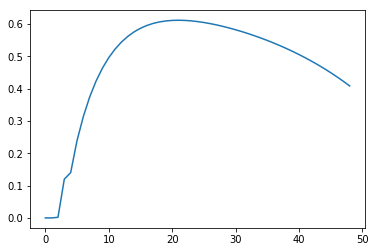

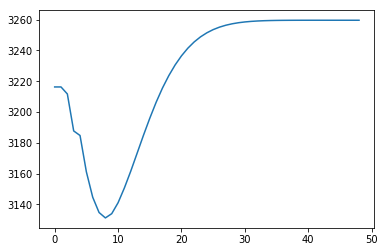

In [9]:
plt.plot(DAC.mutual_info)
plt.figure()
plt.plot(DAC.distortion) # transfer costs
plt.show()

In [ ]:
##axis values???

In [10]:
temps = []
mutual_infos = []
threshold = -.01
for DAC in DACs:
    temps.append(np.array(DAC.temp))
    mutual_infos.append(DAC.mutual_info)
    # # for low enough temperatures the mutual info decreases exponentially, 
    # # filter those less than given threshold
    # accept = mutual_infos[-1] > threshold
    # temps[-1] = temps[-1][accept]
    # mutual_infos[-1] = mutual_infos[-1][accept]
    temps[-1] = temps[-1] / np.max(temps[-1])

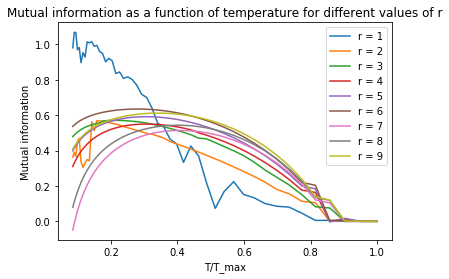

In [11]:
for r, temp, mutual_info in zip(rs, temps, mutual_infos):
    plt.plot(temp, mutual_info, label='r = %d' % r)
    # plt.axvline(x=temp[np.argmax(mutual_info)])
plt.legend(loc=1)
plt.title('Mutual information as a function of temperature for different values of r')
plt.xlabel('T/T_max')
plt.ylabel('Mutual information')
plt.show()

Additionally, plot the maximum MI vs. the distance $r$. What do you observe?

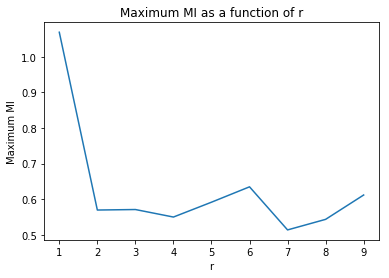

In [12]:
max_mis = [np.max(mi) for mi in mutual_infos]
plt.plot(rs, max_mis)
plt.title('Maximum MI as a function of r')
plt.xlabel('r')
plt.ylabel('Maximum MI')
plt.show()

The maximum mutual information is much higher $r=1$ than for higher values of $r$, which all have a maximum MI around 0.6. This may be because for low $r$, when the clusters aren't separable, the algorithm overfits and finds smaller clusters in the data, with centroids very close to one another (compared to $T$ which is proportional to the variance of each cluster under the distribution $p(x|c) \propto \exp(-\frac{1}{T}\|x-y_c\|^2)$), which may increase the posterior agreement by keeping the distributions $p(c|x)$ relatively flat but still somewhat concentrated around the mode. In fact for $r=1,2$ the mutual information behaves discontinuously with respect to temperature, suggesting that updates to the centroids are changing the assignments of many points at each iteration, while for larger $r$ it changes very smoothly apart from points where presumably new clusters are introduced.

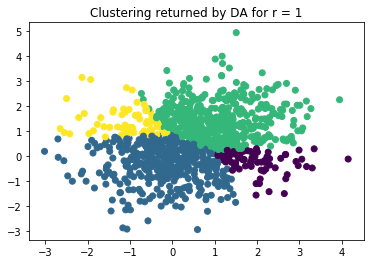

In [13]:
plt.scatter(data[0][0][:,0], data[0][0][:,1], c=DACs[0].predict(data[0][0]))
plt.title('Clustering returned by DA for r = 1')
plt.show()

Investigate the behavior of the maximal MI as a function of the number of data samples $n$ and the data dimension $d$, i.e. plot several curves MI vs. $r$ for different $n$ and $d$. Try to organize the curves into figures, such that one can observe the behavior clearly.

In [14]:
ns = [n_samples//2, n_samples, n_samples*2]
vs = list(map(np.array, [[1,1], [1,1,1], [1,1,1,1]]))
ds = [v.size for v in vs]
data_nd = [[[generate_data(var_1, var_2, r, v, n) for r in rs] for v in vs] for n in ns]

In [15]:
%%time
DACs_nd = []
t = 0
for data_d in data_nd:
    DACs_d = []
    for data in data_d:
        DACs = []
        for i in range(len(rs)):
            DAC = DeterministicAnnealingClustering(n_clusters=4, random_state=42, iters=20, alpha=.95)
            DAC.fit(data[i][0])
            DACs.append(DAC)
        DACs_d.append(DACs)
    DACs_nd.append(DACs_d)

CPU times: user 1min, sys: 3.08 s, total: 1min 3s
Wall time: 34.4 s


In [16]:
temps_nd = []
mutual_infos_nd = []
threshold = -1
for DACs_d in DACs_nd:
    temps_d = []
    mutual_infos_d = []
    for DACs in DACs_d:
        temps = []
        mutual_infos = []
        for DAC in DACs:
            temps.append(np.array(DAC.temp))
            mutual_infos.append(DAC.mutual_info)
            # # for low enough temperatures the mutual info decreases exponentially, 
            # # filter those less than given threshold
            # accept = mutual_infos[-1] > threshold
            # temps[-1] = temps[-1][accept]
            # mutual_infos[-1] = mutual_infos[-1][accept]
            temps[-1] = temps[-1] / np.max(temps[-1])
        temps_d.append(temps)
        mutual_infos_d.append(mutual_infos)
    temps_nd.append(temps_d)
    mutual_infos_nd.append(mutual_infos_d)

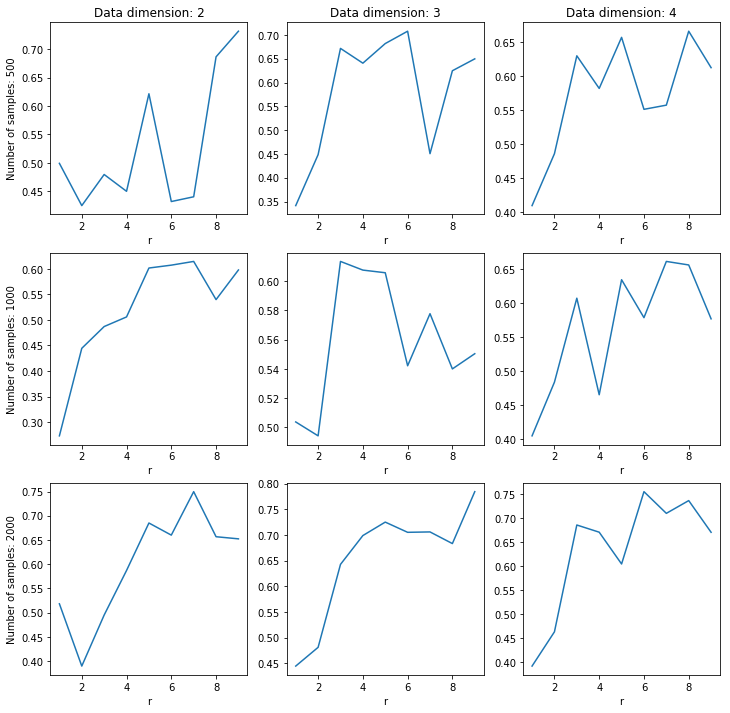

In [17]:
fig, ax = plt.subplots(len(ns), len(ds), squeeze='False')
fig.set_size_inches(12, 12)
for i, n in enumerate(ns):
    for j, d in enumerate(ds):
        max_mis = [np.max(mi) for mi in mutual_infos_nd[i][j]]
        pl = ax[i,j].plot(rs, max_mis)
        if i == 0: # first row
            ax[i,j].set_title('Data dimension: %d' % d)
        if j == 0: # first column
            ax[i,j].set_ylabel('Number of samples: %d' % n)
        ax[i,j].set_xlabel('r')
# plt.figure()
# plt.imshow(perm_label_map, cmap="tab20")
plt.show()

Generally we can observe the maximum MI increasing with r, though it also jumps rapidly up or down especially near the boundaries, and exhibits a lot of variance depending on the samples used. Even though the first sample set also uses 1000 samples and 2 dimensions its curve looks quite different from the corresponding plot above. It may be that in the previous samples it overfit to the data and found more clusters than two but could not do so here.

As the number of samples increase the curve seems to become smoother, which may be attributed to the variance of both the centroids and the posterior agreement decreasing with larger sample size. Also with higher dimensions, the curve seems to become more convex and values of r around 3 look more similar to larger values of r than smaller, which may be because intuitively there is more 'space' with higher dimensions to pack points into and neighborhoods of a given radius contain more volume, and so there can be more well-defined clusters separated by the same distance, which also relates to the curse of dimensionality. However, the overall scale of the mutual information does not seem to vary proportionally either to n or to d.

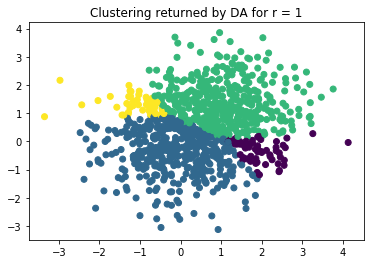

In [18]:
plt.scatter(data_nd[1][0][0][0][:,0], data_nd[1][0][0][0][:,1], c=DACs_nd[1][0][0].predict(data_nd[1][0][0][0]))
plt.title('Clustering returned by DA for r = 1')
plt.show()

Any implementation/computational/numerical issues?

Initially mutual information did not have an apparent peak and decreased exponentially after staying near 0 for a while, up to the order of $-10^8$ for 50 iterations. I initially tried setting a threshold to the mutual information plotted in order to be able to see how it behaves near 0, but later managed to resolve the problem and obtain curves similar to those in the article by sorting the two datasets by their inferred cluster before computing their mutual information, even though this goes against the purpose of working with random transformations.

The results also exhibited very large variance and generating new samples gave completely different graphs, which made them very difficult to interpret conclusively. For that I fixed the random seed so that my observations would not be completely at odds with the output whenever the notebook was rerun, though the results are still difficult to reproduce as in the peak at $r = 1$ for the maximal MI vs. $r$ curves above.

## Problem 3

Use $r$ such that one can not quite distinguish the two clusters (i.e. the maximum MI is not clearly realized with two clusters, i.e. k=2). The two clusters are overlapping so much that they appear as one cluster. Now reduce the variance $\sigma_2$ of the second cluster so that it creates a concentrated peak within the first cluster. Again, plot MI vs. $T$ for different $\sigma_2$ as well as the max MI vs. $\sigma_2$.

In [19]:
var_1 = .7
var_2 = np.linspace(.1, .5, num=9)
r = 2
n_samples = 1000
data = [generate_data(var_1, var, r, v, n_samples) for var in var_2]

In [20]:
%%time
DACs_v = []
for i in range(len(var_2)):
    DAC = DeterministicAnnealingClustering(n_clusters=4, random_state=42, iters=50, alpha=.95)
    DAC.fit(data[i][0])
    DACs_v.append(DAC)

CPU times: user 7.14 s, sys: 432 ms, total: 7.57 s
Wall time: 4.3 s


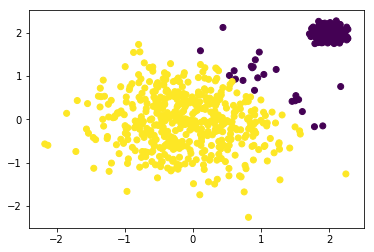

In [21]:
plt.scatter(data[0][0][:,0], data[0][0][:,1], c=DACs_v[0].predict(data[0][0]))
plt.show()

In [22]:
temps = []
mutual_infos = []
threshold = -.01
for DAC in DACs_v:
    temps.append(np.array(DAC.temp))
    mutual_infos.append(DAC.mutual_info)
    
    # # for low enough temperatures the mutual info decreases exponentially, 
    # # filter those less than given threshold
    # accept = mutual_infos[-1] > threshold
    # temps[-1] = temps[-1][accept]
    # mutual_infos[-1] = mutual_infos[-1][accept]
    temps[-1] = temps[-1] / np.max(temps[-1])

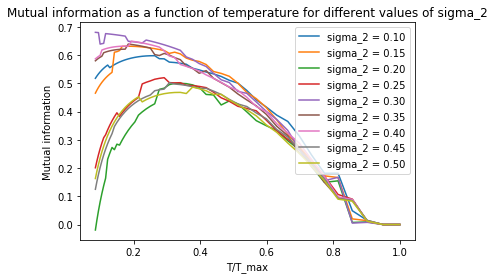

In [23]:
for var, temp, mutual_info in zip(var_2, temps, mutual_infos):
    plt.plot(temp, mutual_info, label='sigma_2 = %.2f' % var)
    # plt.axvline(x=temp[np.argmax(mutual_info)])
plt.legend(loc=1)
plt.title('Mutual information as a function of temperature for different values of sigma_2')
plt.xlabel('T/T_max')
plt.ylabel('Mutual information')
plt.show()

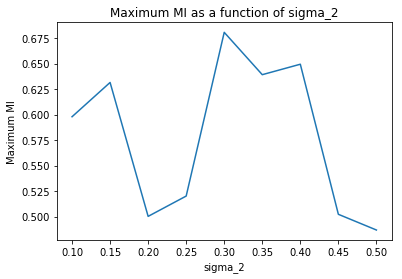

In [24]:
max_mis = [np.max(mi) for mi in mutual_infos]
plt.plot(var_2, max_mis)
plt.title('Maximum MI as a function of sigma_2')
plt.xlabel('sigma_2')
plt.ylabel('Maximum MI')
plt.show()

The maximum MI is in general larger for smaller values of $\sigma_2$, which is reasonable as having smaller variance would make the second cluster more easily separable from the first cluster. However, for $\sigma_2$ around 0.3 it finds a higher mutual information curve above low values of $r$, which may again be due to overfitting.

As before, also investigate the behavior of max MI vs. $\sigma_2$ for different $n,d$.

In [25]:
ns = [n_samples//2, n_samples, n_samples*2]
vs = list(map(np.array, [[1,1], [1,1,1], [1,1,1,1]]))
ds = [v.size for v in vs]
data_nd = [[[generate_data(var_1, var, r, v, n) for var in var_2] for v in vs] for n in ns]

In [26]:
%%time
DACs_nd = []
t = 0
for data_d in data_nd:
    DACs_d = []
    for data in data_d:
        DACs = []
        for i in range(len(var_2)):
            DAC = DeterministicAnnealingClustering(n_clusters=4, random_state=42, iters=20, alpha=.95)
            DAC.fit(data[i][0])
            DACs.append(DAC)
        DACs_d.append(DACs)
    DACs_nd.append(DACs_d)

CPU times: user 51.8 s, sys: 2.7 s, total: 54.5 s
Wall time: 29 s


In [27]:
temps_nd = []
mutual_infos_nd = []
threshold = -1
for DACs_d in DACs_nd:
    temps_d = []
    mutual_infos_d = []
    for DACs in DACs_d:
        temps = []
        mutual_infos = []
        for DAC in DACs:
            temps.append(np.array(DAC.temp))
            mutual_infos.append(DAC.mutual_info)
            # # for low enough temperatures the mutual info decreases exponentially, 
            # # filter those less than given threshold
            # accept = mutual_infos[-1] > threshold
            # temps[-1] = temps[-1][accept]
            # mutual_infos[-1] = mutual_infos[-1][accept]
            temps[-1] = temps[-1] / np.max(temps[-1])
        temps_d.append(temps)
        mutual_infos_d.append(mutual_infos)
    temps_nd.append(temps_d)
    mutual_infos_nd.append(mutual_infos_d)

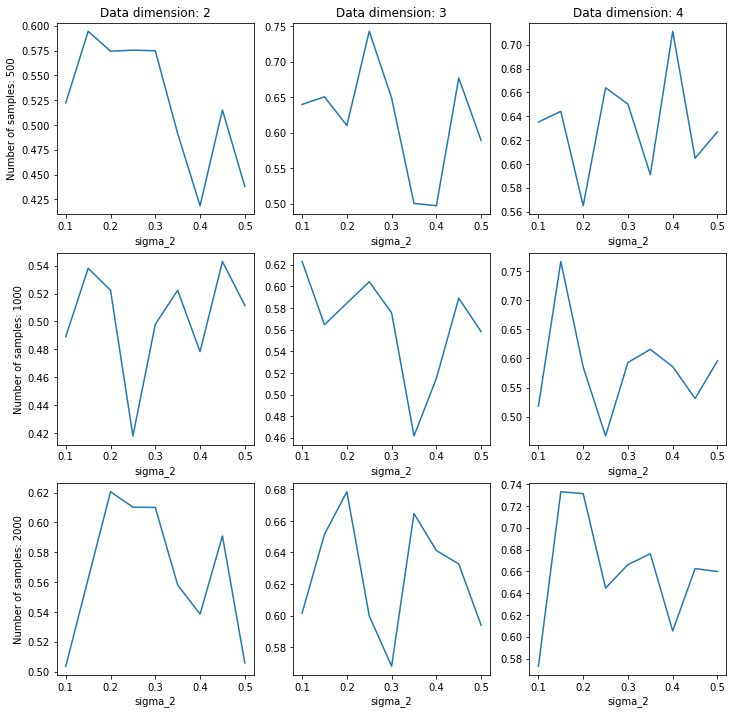

In [28]:
fig, ax = plt.subplots(len(ns), len(ds), squeeze='False')
fig.set_size_inches(12, 12)
for i, n in enumerate(ns):
    for j, d in enumerate(ds):
        max_mis = [np.max(mi) for mi in mutual_infos_nd[i][j]]
        pl = ax[i,j].plot(var_2, max_mis)
        if i == 0: # first row
            ax[i,j].set_title('Data dimension: %d' % d)
        if j == 0: # first column
            ax[i,j].set_ylabel('Number of samples: %d' % n)
        ax[i,j].set_xlabel('sigma_2')
# plt.figure()
# plt.imshow(perm_label_map, cmap="tab20")
plt.show()

There is a general trend towards higher MI for lower $\sigma_2$, similarly to the previous graph, and again a lot of variance due to overfitting. In most cases the maximal MI peaks at a value around 0.15 or 0.2, and reaches its minimum at a point near 0.3 before rising again for larger values of $\sigma_2$, again presumably because the algorithm ends up finding smaller clusters. However for some cases especially with large sample sizes 0.1 is a minimum, which might be because it fails to overfit and break the existing clusters into smaller clusters, and instead finds clusters at the edge of the large first cluster that are either too small or too scattered, as in the case displayed below.

With more samples the peak around $\sigma_2 \leq 0.2$ seems to become in general more apparent, as the second cluster becomes more identifiable against the first cluster. In contrast with higher dimensions the maximal MI increases for $\sigma_2$ large: while the values of MI for $\sigma_2 > 0.3$ are near 0.5 and sometimes as low as 0.4 for two dimensions, they are in general around 0.6 and for the top right graph peaking above 0.7 for dimensions three and four. This may again be because the clusters are better separable with higher dimensions even when the second cluster is large. Here the maximum and minimum values also seem to increase with dimension, though this was not the case before, but the sample size again does not have an apparent effect on the overall scale.

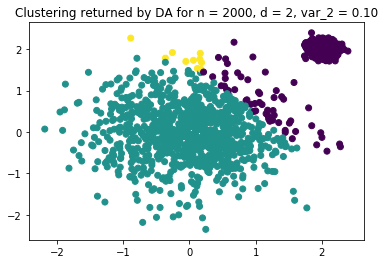

In [33]:
plt.scatter(data_nd[2][0][0][0][:,0], data_nd[2][0][0][0][:,1], c=DACs_nd[2][0][0].predict(data_nd[2][0][0][0]))
plt.title('Clustering returned by DA for n = %d, d = %d, var_2 = %.2f' % (ns[2], ds[0], var_2[0]))
plt.show()

# Extension: Cluster Validity Indices

In this part we are going to try some internal and external cluster validity Indices to assess the obtained clustering. As a small recap, external indices require a ground truth (external information) and calculate the agreement between the true and provided clusterings. Internal indices rely on cluster shapes and positions and don't use any additional knowledge like, for example, labels. See [3] for more details about external and internal indices and [2] for comparison of bunch of internal indices.

For the same set up as in the problem 3 use generated labels to assess the clustering via different external indices . Choose at least 3 indices (e.g. check section 2.4 in [3]) for comparson and explain your choice. Plot score value vs. $r$ for different $\sigma_2$ as well as the max score vs. $\sigma_2$.

Which scores, you think, work better in our case? Why?

Now choose some internal cluster validity indices described in [2] and [3] and evaluate the clustering for setting from Problem 2. Again, choose at least 3 scores and explain your choice. Plot scores for different values of  distance $r$. Also, plot the score vs $\sigma$ for different $r$ and $d$. What do you observe?

# Extra Comments?

If there is anything that you liked or disliked in this exercise, please let us now by noting that down in this box. This will help us improve our exercises. Thank you in advance!

More instructions on how to use the two samples in deterministic annealing, e.g. whether to run the algorithm on both of them or only one, to run it on both of them together or separately etc. would have been very helpful. I couldn't find much information in the paper regarding these implementation details, and initially got strange and erratically varying results that I found difficult to interpret and reconcile with the paper.